Ouvrir ce notebook dans :
<a href="https://colab.research.google.com/github/joanglaunes/deep_learning_image/blob/main/TP_deblur_PnP_session.ipynb" target="_blank">Google Colab</a>
ou
<a href="https://rosenblatt.ens.math-info.univ-paris5.fr/hub/user-redirect/git-pull?repo=https%3A%2F%2Fgithub.com%2Fjoanglaunes%2Fdeep_learning_image&urlpath=tree%2Fdeep_learning_image%2FTP_deblur_PnP_session.ipynb&branch=main" target="_blank">Rosenblatt</a>

Méthode Plug-And-Play pour le deblurring
========================================

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import torch

device = "cuda:0" if torch.cuda.is_available() else "cpu"

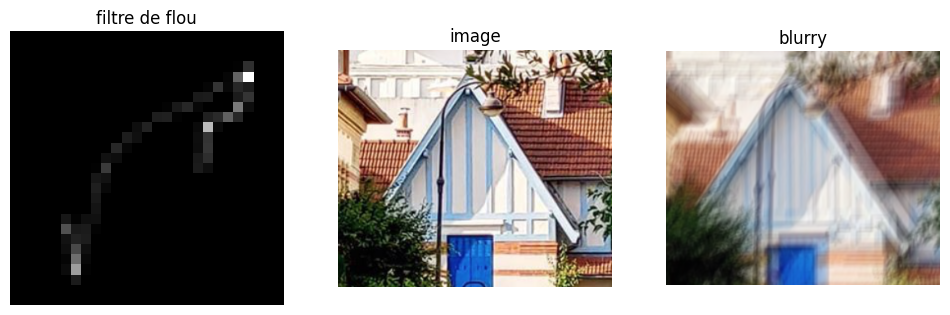

In [4]:
def im2batch(x):
    if len(x.shape)==2:
        return x[None,None,...]
    else:
        return x.permute((2,0,1))[:,None,...]

def batch2im(x):
    x = x.squeeze()
    if len(x.shape)==2:
        return x
    else:
        return x.permute((1,2,0))

def conv2d(x,h):
    x, h = im2batch(x), im2batch(h)
    return batch2im(torch.nn.functional.conv2d(x,h))

def conv2d_transpose(x,h):
    x, h = im2batch(x), im2batch(h)
    return batch2im(torch.nn.functional.conv_transpose2d(x,h))


def imshow(*x, title=None):
    plt.figure(figsize=(12,6))
    n = len(x)
    for k in range(n):
        plt.subplot(1,n,k+1)
        plt.imshow(x[k].cpu(), cmap="gray")
        if title is not None:
            plt.title(title if n==1 else title[k]);
        plt.axis("off")

ind_filtre = 3

h = torch.from_numpy(np.load("Levin09.npy", allow_pickle=True)[ind_filtre]).to(dtype=torch.float32, device=device)
x_org = torch.from_numpy(plt.imread("zoom.png")).to(device)

y = conv2d(x_org,h)

imshow(h,x_org,y, title=("filtre de flou","image","blurry"))

__Question 1__ Ecrire quelques pas de descente de gradient simple pour le débruitage de l'image $y$, pour la minimisation de la fonction
$$J_0(x)=\frac12\|Ax-y\|^2.$$ Afficher les résultats et commenter.

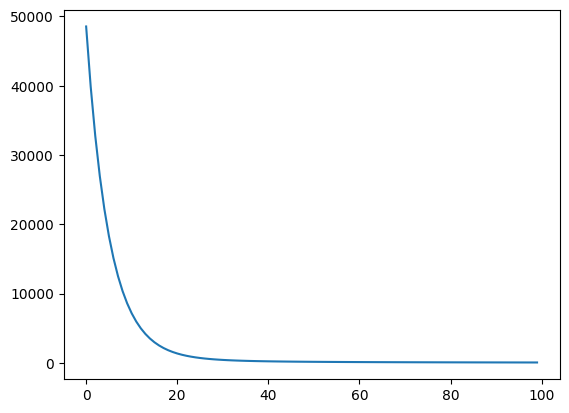

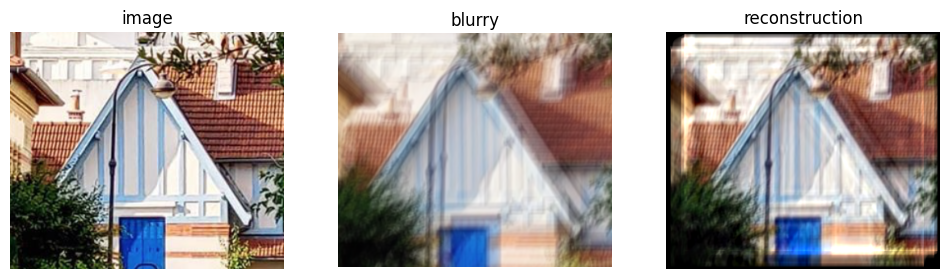

In [5]:
def grad_desc(y, Niter, eta):
    x = torch.zeros(x_org.shape, device=device)
    vals = torch.zeros(Niter)
    for k in range(Niter):
        Ax = conv2d(x,h)
        vals[k] = .5*torch.sum((Ax-y)**2)
        GJx = conv2d_transpose(Ax-y,h)
        x = x - eta * GJx
        x = x.clip(0,1)
    return x, vals

x, vals = grad_desc(y, Niter=100, eta=0.1)
plt.plot(vals)
imshow(x_org,y,x, title=("image","blurry","reconstruction"))

On teste avec du bruit:

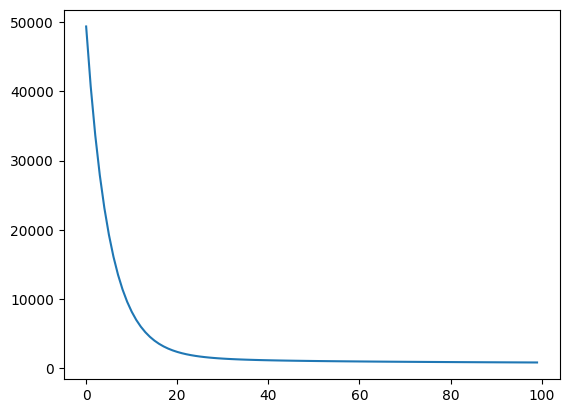

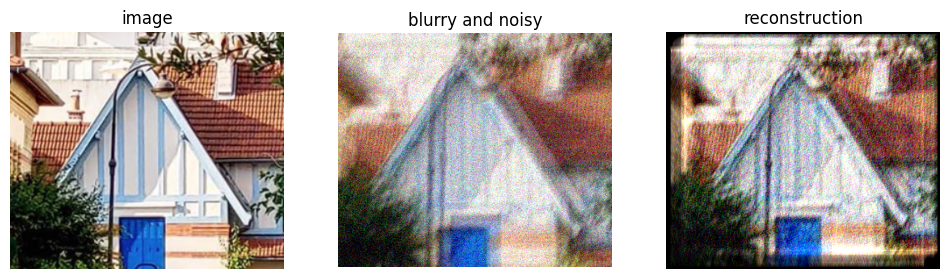

In [6]:
y_b = (y + 0.1 * torch.randn(y.shape, device=device)).clip(0,1)
x, vals = grad_desc(y_b, Niter=100, eta=0.1)
plt.plot(vals)
imshow(x_org,y_b,x, title=("image","blurry and noisy","reconstruction"))

__Question 2__ Choisir un réseau préentrainé dans les notebooks précédents du cours, et appliquer la méthode Plug-And-Play pour minimiser
$$J_\sigma(x)=\frac12\|Ax-y\|^2+\sigma^2 R(x),$$ 
où $R$ est un terme de régularisation implicite dont l'opérateur proximal est donné par l'application du réseau débruiteur.
Afficher les résultats et commenter.